In [1]:
import pandas as pd
import numpy as np
import os
import sys
import random
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from itertools import product

sys.path.extend([
                '../src',
                '../data',
                ])

from utils import run_nested_cv_3a

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("CPU")
    
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

#data
left = pd.read_csv('../data/left.csv')
right = pd.read_csv('../data/right.csv')
affected = pd.read_csv('../data/affected.csv')
unaffected = pd.read_csv('../data/unaffected.csv')

right['limb'] = 1
left['limb'] = 2
affected['limb'] = 3
unaffected['limb'] = 4

affected['subject'] = affected['subject'] + 10
unaffected['subject'] = unaffected['subject'] + 10

combined = pd.concat([unaffected, 
                      affected, 
                      right, 
                      left], ignore_index=True)

architecture = {
               'num_filters': [50, 25],
               'filter_sizes': [5, 5],
               'pool_sizes': [5, 5]
               }

CPU


2025-07-09 22:42:56.819158: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x354de60a0>, 'kernel_init': <keras.initializers.initializers_v2.HeNormal object at 0x354de6250>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x32287a940>, 'optimizer': 'adam'} with score: 0.289


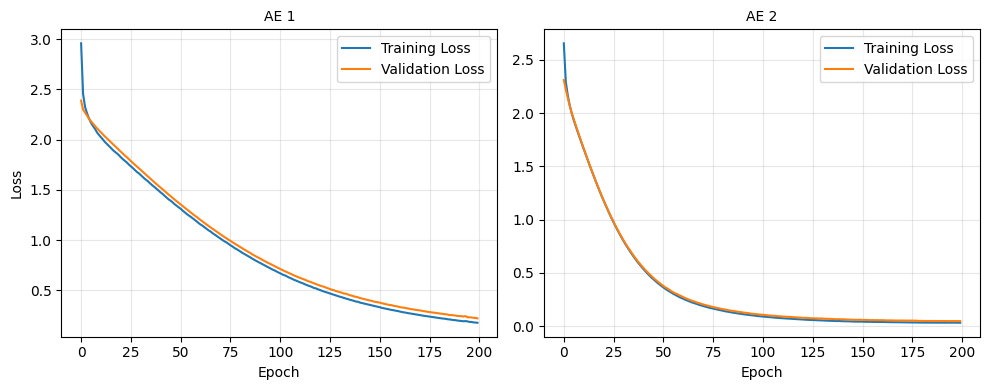

Limb: 1 Subject: 1 Youden Index: 0.125 Sensitivity: 1.0 Specificity: 0.125
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x354de60a0>, 'kernel_init': <keras.initializers.initializers_v2.HeNormal object at 0x354de6250>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x32287a940>, 'optimizer': 'adam'} with score: 0.274


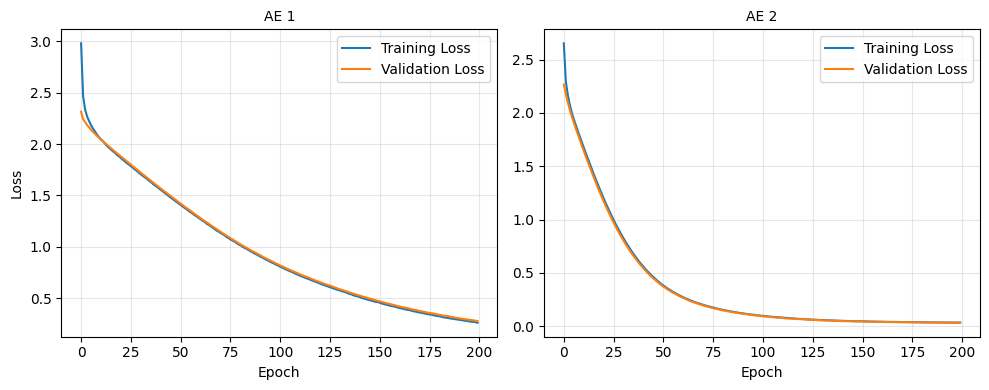

Limb: 1 Subject: 2 Youden Index: 0.19602698650674655 Sensitivity: 0.9891304347826086 Specificity: 0.20689655172413793
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x354de60a0>, 'kernel_init': <keras.initializers.initializers_v2.HeNormal object at 0x354de6250>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x32287a940>, 'optimizer': 'adam'} with score: 0.285


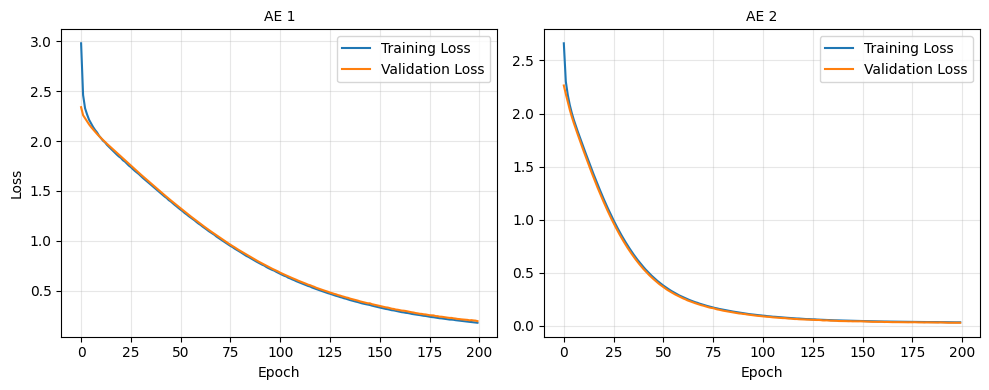

Limb: 1 Subject: 3 Youden Index: 0.3913043478260869 Sensitivity: 1.0 Specificity: 0.391304347826087
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x354de60a0>, 'kernel_init': <keras.initializers.initializers_v2.HeNormal object at 0x354de6250>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x32287a940>, 'optimizer': 'adam'} with score: 0.286


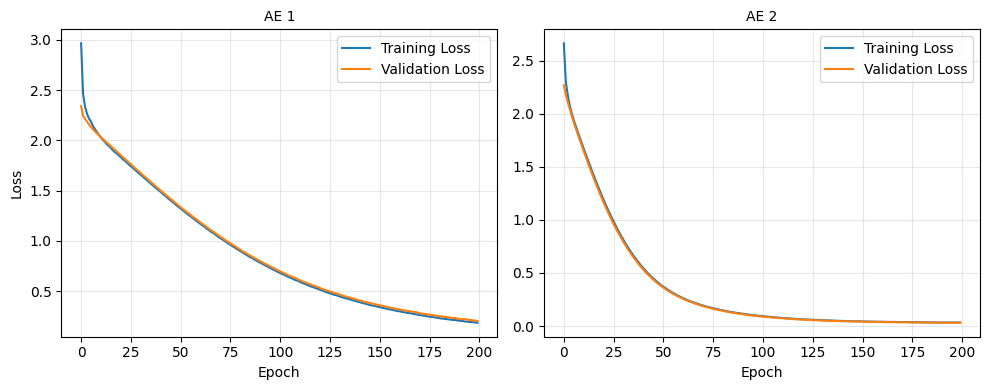

Limb: 1 Subject: 4 Youden Index: 0.32000000000000006 Sensitivity: 1.0 Specificity: 0.32
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x354de60a0>, 'kernel_init': <keras.initializers.initializers_v2.HeNormal object at 0x354de6250>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x32287a940>, 'optimizer': 'adam'} with score: 0.316


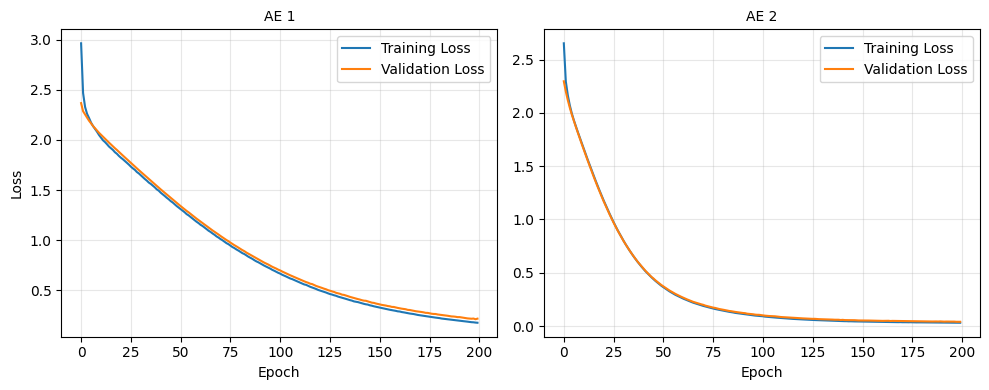

Limb: 1 Subject: 5 Youden Index: 0.0 Sensitivity: 1.0 Specificity: 0.0
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x354de60a0>, 'kernel_init': <keras.initializers.initializers_v2.HeNormal object at 0x354de6250>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x32287a940>, 'optimizer': 'adam'} with score: 0.303


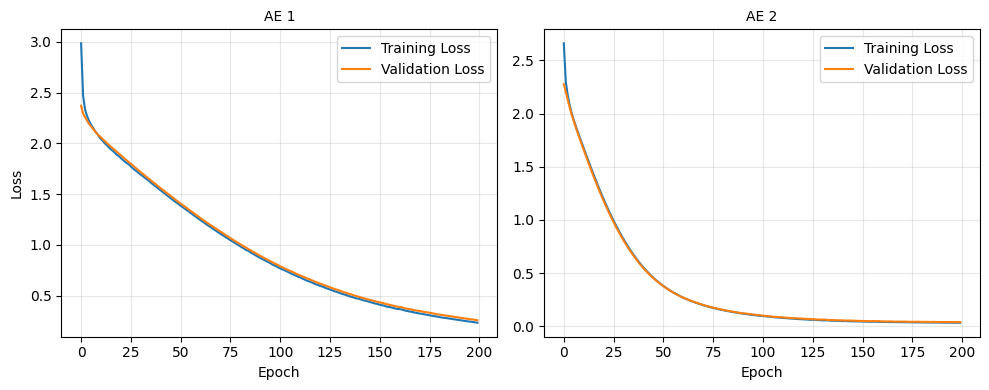

Limb: 1 Subject: 6 Youden Index: 0.36878004417305443 Sensitivity: 0.9385474860335196 Specificity: 0.43023255813953487
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x354de60a0>, 'kernel_init': <keras.initializers.initializers_v2.HeNormal object at 0x354de6250>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x32287a940>, 'optimizer': 'adam'} with score: 0.300


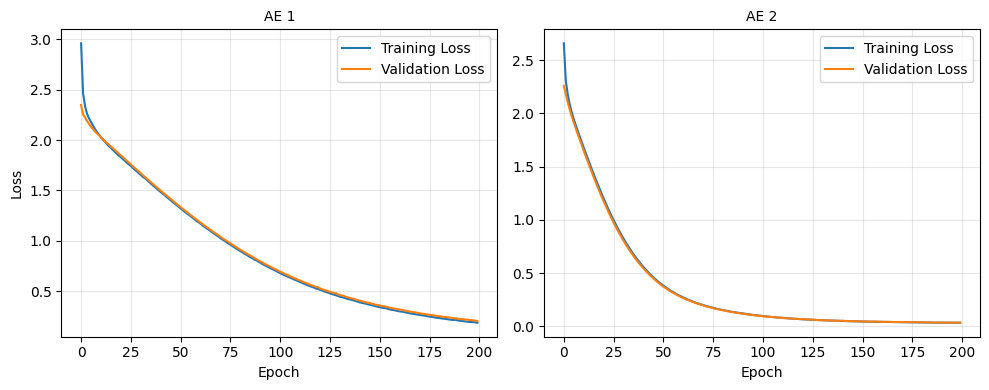

Limb: 1 Subject: 7 Youden Index: 0.03837622005323871 Sensitivity: 0.9948979591836735 Specificity: 0.043478260869565216
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x354de60a0>, 'kernel_init': <keras.initializers.initializers_v2.HeNormal object at 0x354de6250>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x32287a940>, 'optimizer': 'adam'} with score: 0.304


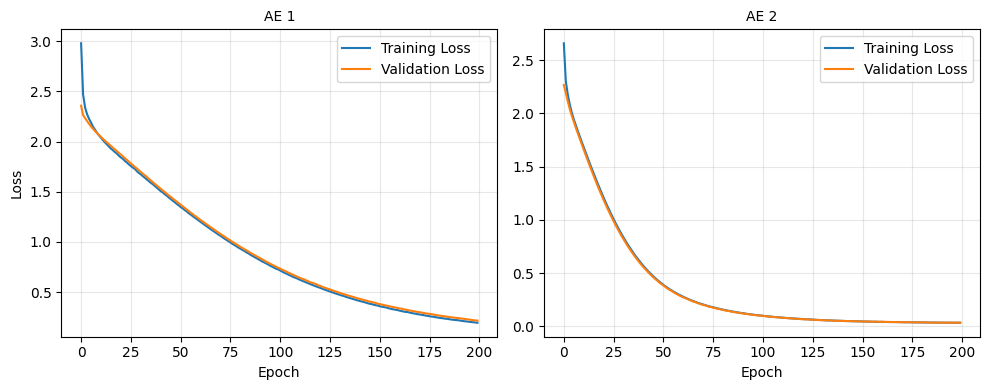

Limb: 1 Subject: 8 Youden Index: 0.09375 Sensitivity: 1.0 Specificity: 0.09375
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x354de60a0>, 'kernel_init': <keras.initializers.initializers_v2.HeNormal object at 0x354de6250>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x32287a940>, 'optimizer': 'adam'} with score: 0.272


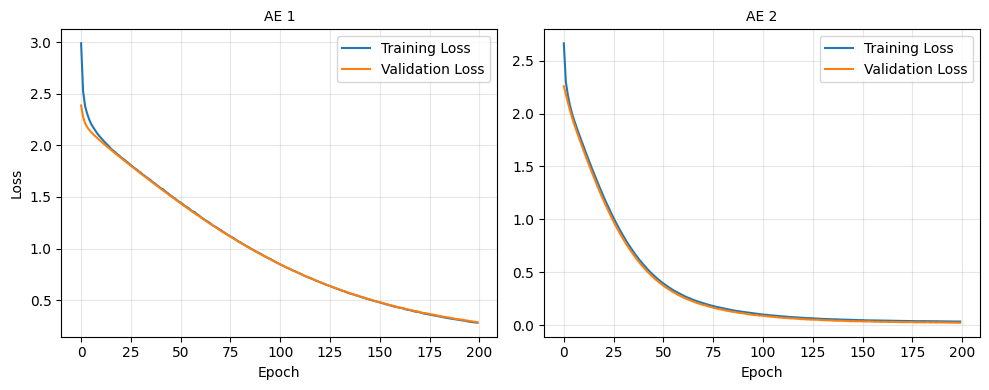

Limb: 1 Subject: 9 Youden Index: 0.12962962962962954 Sensitivity: 1.0 Specificity: 0.12962962962962962
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x354de60a0>, 'kernel_init': <keras.initializers.initializers_v2.HeNormal object at 0x354de6250>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x32287a940>, 'optimizer': 'adam'} with score: 0.273


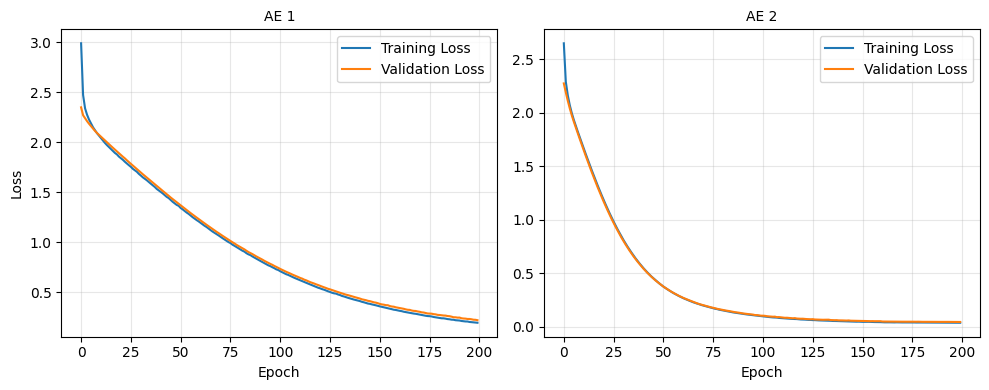

Limb: 1 Subject: 10 Youden Index: 0.19713697604790426 Sensitivity: 0.9940119760479041 Specificity: 0.203125
0.18600042042366605 0.12866097078671201


In [2]:

approach = 3
filename = f'../results/approach3a/limb_nested_cv_right.csv'

window_size = 100
epochs = 200
batch_size = 32

class_loss = False
plot_hist = False

error_func = 'mae'

X = right[['ax', 'ay', 'az']]
y = right['gnd']
subjects = right['subject']
limbs = right['limb']

hp = {
        'activation': ['tanh'],
        'kernel_init': [tf.keras.initializers.HeNormal(seed=42), ],
        'bias_init': [tf.keras.initializers.Zeros()],
        'optimizer':['adam'],
        'loss': [tf.keras.losses.mean_squared_error,],
        'learning_rate': [ 0.0001],
        'batch_norm': [True]
    }

results_3a = run_nested_cv_3a(window_size,             
                              X=X,                         
                              y=y,                        
                              subjects=subjects,           
                              limbs=limbs,                      
                              architecture=architecture,   
                              hp_grid=hp,
                              epochs=epochs,                  
                              batch_size=batch_size,             
                              class_loss=False,           
                              plot_hist=True,            
                              error_func='None')

print(np.mean(results_3a['youden_index']), np.std(results_3a['youden_index']))